<h1>TWITTER SENTIMENT ANALYSIS</h1>

<h2>INTRODUCTION</h2>

Gabapentinoids are drugs that are derivatives of the inhibitory neurotransmitter gamma-Aminobutyric acid (GABA) (i.e., GABA analogues). Citing the FDA website: "Gabapentinoids are FDA-approved to treat a variety of conditions including partial seizures and nerve pain from spinal cord injury, shingles, and diabetes. Other approved uses include fibromyalgia and restless legs syndrome. Gabapentin was first approved in 1993 and pregabalin was first approved in 2004. Gabapentin is marketed under the brand names Neurontin and Gralise, and also as generics. Gabapentin enacarbil is marketed under the brand name Horizant. Pregabalin is marketed under the brand names Lyrica and Lyrica CR, and also as generics. Pregabalin is a Schedule V controlled substance, which means it has a lower potential for abuse among the drugs scheduled by the Drug Enforcement Administration (DEA), but may lead to some physical or psychological dependence."

Apart from the uses that are FDA-approved, gabapentinoids are widely prescribed for many off-label uses: all kinds of pain, bipolar disorder, anxiety, depression, insomnia, endometriosis, hot flushes... and are considered a safe alternative to opioids. They are also prescribed to pets. 

For many people, gabapentinoids are 'miracle drugs' and 'godsends'. For many people (including myself), they are ineffective and have many side effects and adverse reactions. That's the reason why I'm going to try to perform a sentiment analysis on tweets that mention these drugs.

<h2>DATA</h2>

<h3>Data Gathering</h3>

To gather the tweets I've used the twint library and the nest_asyncio library. That's the code that I used to gather tweets that mention 'gabapentin':

In [ ]:
import twint
import nest_asyncio
nest_asyncio.apply()

c = twint.Config()

c.Search = ['gabapentin']       # topic
c.Limit = 5000    # number of Tweets to scrape
c.Store_csv = True       # store tweets in a csv file
c.Output = "gabapentin.csv"     # path to csv file

twint.run.Search(c)

I repeated the same process with the terms 'gabapentinoids', 'neurontin', 'pregabalin' and 'Gralise'. I also tried to gather tweets with the terms 'Lyrica' and 'Horizant' but I got mostly song lyrics and tweets in german.

<h3>Data Cleaning and Preprocessing</h3>

First, we import all the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import preprocessor as p
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
from textblob import TextBlob
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
from PIL import Image
from flair.models import TextClassifier
from flair.data import Sentence
from segtok.segmenter import split_single

pd.set_option('display.max_columns', None)

pd.set_option('display.max_colwidth', None)

We create a list with all the csv files to join together in a single dataframe:

In [2]:
csv_files = ['gabapentin.csv', 'gabapentinoids.csv', 'pregabalin.csv', 'neurontin.csv', 'gralise.csv']

tweets = []

for filename in csv_files:
    data = pd.read_csv(filename, encoding='utf-8')
    tweets.append(data)
    
tweets = pd.concat(tweets)

tweets.shape

(18824, 36)

Next, we drop duplicated tweets

In [3]:
tweets.drop_duplicates(subset='tweet', inplace=True)

tweets.shape

(16133, 36)

We check the info of the dataframe

In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16133 entries, 0 to 1549
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               16133 non-null  int64  
 1   conversation_id  16133 non-null  int64  
 2   created_at       16133 non-null  object 
 3   date             16133 non-null  object 
 4   time             16133 non-null  object 
 5   timezone         16133 non-null  int64  
 6   user_id          16133 non-null  int64  
 7   username         16133 non-null  object 
 8   name             16133 non-null  object 
 9   place            13 non-null     object 
 10  tweet            16133 non-null  object 
 11  language         16133 non-null  object 
 12  mentions         16133 non-null  object 
 13  urls             16133 non-null  object 
 14  photos           16133 non-null  object 
 15  replies_count    16133 non-null  int64  
 16  retweets_count   16133 non-null  int64  
 17  likes_count  

It looks like we have several columns empty or almost empty, so we drop them. Also, we need to change 'created_at' to datetime.

In [5]:
tweets.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [6]:
cols = ['place', 'quote_url', 'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt','retweet_id', 'retweet_date', 
        'translate', 'trans_src', 'trans_dest']

tweets = tweets.drop(cols, axis = 1)

tweets['created_at'] = pd.to_datetime(tweets['date'] + ' ' + tweets['time'])

tweets['created_at'].head()

0   2021-06-29 12:45:20
1   2021-06-29 11:21:25
2   2021-06-29 11:20:27
3   2021-06-29 11:08:02
4   2021-06-29 10:34:18
Name: created_at, dtype: datetime64[ns]

We are going to check some columns to see if it's true that they doesn't have null values

In [7]:
tweets['photos'].head()

0    ['https://pbs.twimg.com/tweet_video_thumb/E5C0oqWXIAIqa_R.jpg']
1                                                                 []
2                                                                 []
3                                                                 []
4                                                                 []
Name: photos, dtype: object

In [8]:
tweets['hashtags'].head()

0    []
1    []
2    []
3    []
4    []
Name: hashtags, dtype: object

We still have null values, and they seem to be represented with brackets, so we replace them with np.nan

In [9]:
tweets = tweets.replace('[]', np.nan)

tweets.isna().sum()

id                     0
conversation_id        0
created_at             0
date                   0
time                   0
timezone               0
user_id                0
username               0
name                   0
tweet                  0
language               0
mentions           15166
urls               12367
photos             14893
replies_count          0
retweets_count         0
likes_count            0
hashtags           14033
cashtags           15844
link                   0
retweet                0
video                  0
reply_to            8612
dtype: int64

We have more columns that are almost empty. Before we drop them, we check other columns to see if they have useful information.

In [10]:
tweets.timezone.value_counts()

200    16133
Name: timezone, dtype: int64

we decide to keep the next columns:

In [11]:
cols = ['id', 'conversation_id', 'created_at', 'date', 'time','user_id', 'tweet', 'language', 'replies_count', 
        'retweets_count', 'likes_count']

tweets = tweets[cols]

tweets.head(2)

,id,conversation_id,created_at,date,time,user_id,tweet,language,replies_count,retweets_count,likes_count
0,1409825305607426052,1409825305607426052,2021-06-29 12:45:20,2021-06-29,12:45:20,1119398768934359041,"Pain levels are a bit out of my control today, i'm drowsy due to the Gabapentin painkillers but at least I can nap without worrying too much. &lt;3 Drowsy waff is drowsy. Music and napping feels like a good combination. &lt;3 https://t.co/nS5ndurS6I",en,0,0,1
1,1409804186221309956,1409804186221309956,2021-06-29 11:21:25,2021-06-29,11:21:25,1951365738,州に感染者6人出たからひっさびさのロックダウンでマスクすぐ忘れちゃう〜,ja,0,0,0


We are only interested in tweets in English, so we check the values of the 'languages' column, so we filter the dataframe.

In [12]:
tweets = tweets[tweets['language'] == 'en']

tweets.shape

(13776, 11)

The next step will be cleaning the tweets of mentions, emojis, urls and other features. We use the library preprocessor to do it. 

In [13]:
def preprocess_tweet(row):
    text = row['tweet']
    text = p.clean(text)
    return text

In [14]:
tweets['tweet'] = tweets.apply(preprocess_tweet, axis=1)

tweets[['id', 'tweet']].sample(5)

,id,tweet
2841,1399080443450957824,"I take Meloxican mg x dialy hr b4 bed Gabapentin (2) mg dialy hr b4 bed Phy Therpay little help Injections some help They have ""offered"" recently full spinal Fusion. Leaning towards NO Artificial disc replacement I have ?'s I am gonna ask about pain pump"
4699,1134290685576830977,Neurontin and Lyrica are a Death Sentence for New Brain Synapses: Shocking Study
1101,227468629317410816,All about . Tagged on
1694,1307122853146431488,"And ask for Neurontin if you can take it, helps A LOT with that kind of nerve pain"
3810,1394118947851563011,Did you know that HIKAL is the largest supplier of GABAPENTIN Globally.


Now, let's set 'created_at' as the column index of the dataframe and sort the values.

In [15]:
tweets = tweets.set_index('created_at')

tweets.sort_index(inplace=True)

tweets[['id', 'tweet']].sample(5)

,id,tweet
created_at,,
2019-05-20 16:35:26,1130482166226407424,How did use of gabapentinoids on acute pain services contribute to this?
2021-06-09 20:19:52,1402691934246817796,It’s just a name of disease. She can get a vaccination for it after it goes away. Tell mama she needs Neurontin for the pain.
2021-05-25 09:28:05,1397092087385006083,Gabapentin: too risky in addictions? via
2020-01-01 14:40:47,1212368071056343040,"On one hand, my dad finally did get off the smack, by help of a substitute drug prescribed for his Agent Orange tremors (Neurontin). On the other hand, the memory takes me back to the time when he did all the wrong things, and wasn't there for us."
2021-06-13 05:14:00,1403913518752014336,Yes we did. The double dose of gabapentin seems to be working well. Hooray. xxx


The next step in the cleaning process is put all the tweets in lowercase, eliminate punctuation and extra whitespaces, and change 'amp' for 'and.

In [16]:
tweets['tweet'] = tweets['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ').str.replace('amp', 'and')

tweets[['id','tweet']].sample(5)

,id,tweet
created_at,,
2013-12-06 01:27:38,408754572140625920,got a letter from my insurance company saying they won t cover my gralise after the first of the year
2020-03-26 09:23:50,1243091275664023552,is the generic name for the widely prescribed doctors use it to treat seizures post herpetic and restless leg syndrome in most cases it is alongside other medications
2021-05-11 22:25:28,1392214293215686656,i take gabapentin for anxiety it s great
2021-05-28 23:15:39,1398387516315561984,i had a condition where my right arm would spasm every seconds or so for about an hour usually at pm weird right also annoying as fuck and exhausting gabapentin stopped it so quickly that i forgot it was supposed to be happening
2021-05-07 05:29:40,1390509108739063810,in the case pfizer agreed to pay 430 million to federal and state governments and pleaded guilty to criminal charges of illegally marketing epilepsy drug neurontin for migraine headaches pain and bipolar disorder


I've realized that some tweets don't include any of the search terms, probably because they were hashtags, so I'm going to select only the tweets that contain the terms 'gabapentinoids', 'gabapentin', 'Neurontin, 'lyrica', 'pregabalin', 'gralise' and 'horizant'.

In [17]:
tweets = tweets[tweets['tweet'].str.contains('gabapentinoids|gabapentin|neurontin|lyrica|pregabalin|gralise|horizant')]

tweets[['id', 'tweet']].sample(5)

,id,tweet
created_at,,
2021-04-27 21:20:23,1387124484117831685,this gabapentin is giving me crazy dreams
2021-05-14 05:16:28,1393042501812908033,gabapentin is starting to help my arm in a way tylenol couldn t it seems like there are some nerve issues
2021-05-01 17:37:36,1388517970276753413,i learned a lot from this summary we should reconsider using gabapentin in our eras protocols not much benefit and can lead to complications and increased los
2021-04-30 03:36:53,1387944010954670084,i take gabapentin too for back nerve pain it works pretty well but it is also a great sleeping pill they say it is addicting so keep that in mind
2021-06-09 17:35:03,1402650456384540672,they got me on percocet and gabapentin also the rest of my life


The next steps in the process are tokenization and removal of stopwords, we use the nltk library

In [18]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
def identify_tokens(row):
    tweet = row['tweet']
    tokens = nltk.word_tokenize(tweet)
    return tokens

tweets['clean_tweet'] = tweets.apply(identify_tokens, axis=1)

tweets[['id', 'tweet', 'clean_tweet']].sample(5)

,id,tweet,clean_tweet
created_at,,,
2017-11-11 21:46:13,929450210761302016,are we over prescribing gabapentinoids in order to avoid opioids probably but we re also over prescribing opioids,"[are, we, over, prescribing, gabapentinoids, in, order, to, avoid, opioids, probably, but, we, re, also, over, prescribing, opioids]"
2019-08-24 22:29:04,1165360398410887168,neurontin how interesting i wouldn t have thought that would have addiction potential at all i know pfizer lost a lawsuit about it they pushed it a lot so drs over prescribed i knew a pfizer drug rep who took it every day and kept wanting me to take some for no reason,"[neurontin, how, interesting, i, wouldn, t, have, thought, that, would, have, addiction, potential, at, all, i, know, pfizer, lost, a, lawsuit, about, it, they, pushed, it, a, lot, so, drs, over, prescribed, i, knew, a, pfizer, drug, rep, who, took, it, every, day, and, kept, wanting, me, to, take, some, for, no, reason]"
2021-05-24 18:10:08,1396861078093586432,what disease can gabapentin be used for,"[what, disease, can, gabapentin, be, used, for]"
2019-05-09 03:36:15,1126299812800933888,did you see the latest article about gabapentinoids today more ammunition for your fight make sure you read and retweet it good luck u janice,"[did, you, see, the, latest, article, about, gabapentinoids, today, more, ammunition, for, your, fight, make, sure, you, read, and, retweet, it, good, luck, u, janice]"
2019-11-13 13:58:48,1194600502094368770,it s sad because i have seen it help people in a case to case basis lupus sufferers benefit from it greatly they dont need to take lyrica and neurontin that have major side effects right now this is a very natural solution of the earth that god gives us no i dont use,"[it, s, sad, because, i, have, seen, it, help, people, in, a, case, to, case, basis, lupus, sufferers, benefit, from, it, greatly, they, dont, need, to, take, lyrica, and, neurontin, that, have, major, side, effects, right, now, this, is, a, very, natural, solution, of, the, earth, that, god, gives, us, no, i, dont, use]"


In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))      

def remove_stops(row):
    my_list = row['clean_tweet']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

tweets['clean_tweet'] = tweets.apply(remove_stops, axis=1)

tweets[['id', 'tweet', 'clean_tweet']].sample(5)

,id,tweet,clean_tweet
created_at,,,
2020-01-23 11:30:19,1220292670536310785,cw meds pain sometimes i forget how much my meds help but i ve had good reminders recently at dnd my dm said he was amazed at my mobility and how i could play w my dog i forgot to take my afternoon dose of neurontin today and omg i m more of a mess than i ve been in weeks,"[cw, meds, pain, sometimes, forget, much, meds, help, good, reminders, recently, dnd, dm, said, amazed, mobility, could, play, w, dog, forgot, take, afternoon, dose, neurontin, today, omg, mess, weeks]"
2020-05-01 13:00:00,1256176539064025091,icymi new publication for stakeholders initially safer medication use opioids and gabapentinoids how and when can these drugs be safely co prescribed,"[icymi, new, publication, stakeholders, initially, safer, medication, use, opioids, gabapentinoids, drugs, safely, co, prescribed]"
2020-07-24 18:12:24,1286695737041072133,has advised against gabapentinoids and warned of limited evidence with nsaids for sciatica in draft guidance 3 5,"[advised, gabapentinoids, warned, limited, evidence, nsaids, sciatica, draft, guidance, 3, 5]"
2015-04-15 12:29:34,588288044001812482,depomed actavis settle gralise anda patent infringement litigation,"[depomed, actavis, settle, gralise, anda, patent, infringement, litigation]"
2014-11-21 13:27:38,535771515946418176,the economics of the gabapentinoids,"[economics, gabapentinoids]"


<h2>EXPLORATORY DATA ANALYSIS</h2>

First of all, let’s look at the oldest and the newest tweets creation time in our data set.

In [21]:
# Print the minimum datetime
print("Since:",tweets.index.min())

# Print the maximum datetime
print("Until",tweets.index.max())

Since: 2011-01-29 01:35:33
Until 2021-07-08 18:34:36


Let's see the distribution of tweets per year

In [22]:
tweets_per_year = tweets['id'].groupby(tweets.index.year).count()

tweets_per_year

created_at
2011     242
2012     279
2013      85
2014     161
2015      73
2016     115
2017     545
2018     479
2019    2533
2020    2101
2021    6181
Name: id, dtype: int64

Most of the tweets were published in the last three years, especially in 2021

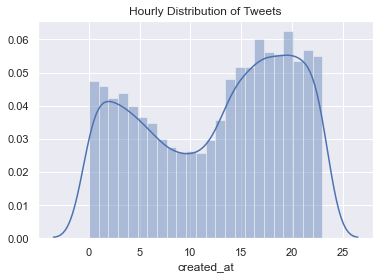

In [23]:
# Set the seaborn style
sns.set()
# Plot the histogram of hours
sns.distplot(tweets.index.hour, bins=24)
plt.title("Hourly Distribution of Tweets")
plt.show()

Next, let's display the tweets with more likes.

In [24]:
display(tweets.sort_values(by=["likes_count", ], axis=0, ascending=False)[["tweet","likes_count"]].head(10))

,tweet,likes_count
created_at,,
2021-04-07 13:15:18,absolutely agree patients need to be managed away from opioids gabapentinoids so nice can you mandate that the govt set ups more pain clinics recruits more psychologists physios ots etc without that gps and patients are stuck,374
2021-06-04 02:48:55,this asshole got mg gabapentin and was still so violent at the vet that they couldn t get him out of his carrier they want me to reschedule and give mg of gabapentin next time freaking punk,248
2021-04-23 06:26:34,for some reason tobias s default state is him with his tongue out during the hours that he s pretty exhausted from gabapentin i have to always check that his tongue isn t hanging out even touching it doesn t make him put it back in,228
2019-09-24 22:21:58,mechanism of pregabalin gabapentin pregabalin lyrica and gabapentin neurontin are structural analogs of gaba but they do not work by interacting with gaba instead both drugs act as inhibitors of α2δ subunit containing voltage dependent calcium channels vdccs,205
2021-06-07 20:14:33,we also tried daily gabapentin first then elavil as non opiate pain control options neither of them worked last week i started him on a stronger long acting opiate twice a day i would be lying if i didn t admit i was questioning whether i was doing the right thing,179
2021-05-13 04:26:16,hi pals fanks fer all prayers n well wishes i ve been home about hours n finally getting comfy wif da gabapentin da nice vet dogtor said everyfing went well today n i should be chasing critters by mid july yahooo aroooo,179
2019-09-10 15:11:25,opioid painkillers for acute pain and injury excluding use in cancer patients only cancer patients have long term pain i must be imagining mine gabapentinoids used to treat epilepsy anxiety and nerve related pain do you think these things just magically go away,170
2021-06-22 02:45:18,older adults receiving gabapentinoids are at risk of eeriencing a potentially harmful prescribing cascade peripheral edema leading to diuretic use rather than discontinuing or reducing the dose of the gabapentinoid,156
2020-04-29 12:47:40,new article on pregabalin and gabapentin for pain no evidence for the use of gabapentinoids to improve pain in sciatica low back pain and other off label use conditions,153


Tweets with more retweets

In [25]:
display(tweets.sort_values(by=["retweets_count", ], axis=0, ascending=False)[["tweet","retweets_count"]].head(10))           

,tweet,retweets_count
created_at,,
2017-08-16 12:02:40,gabapentinoids should not be used for chronic low back pain meta analysis concludes,99
2019-09-24 22:21:58,mechanism of pregabalin gabapentin pregabalin lyrica and gabapentin neurontin are structural analogs of gaba but they do not work by interacting with gaba instead both drugs act as inhibitors of α2δ subunit containing voltage dependent calcium channels vdccs,86
2021-02-08 18:10:56,in pfizer s subsidiary warner lambert was fined 430 million to resolve criminal charges and civil liabilities for the fraudulent promotion of its epilepsy drug neurontin paying and bribing doctors to prescribe it for uses not approved by the fda,85
2021-04-21 17:05:44,neurontin gabapentin is being used widely in us now uk how well does it work for your pain next tweet side effects retweet please,82
2020-04-29 12:47:40,new article on pregabalin and gabapentin for pain no evidence for the use of gabapentinoids to improve pain in sciatica low back pain and other off label use conditions,79
2020-11-06 19:42:04,summary of buddy s monthly eenses if we have a vet housecall 160 to arrive at door all else extra neurontin trazadone tramadol rimadyl 80 month in dasuquin 120 140 pee pads 180 in nutri,69
2021-04-07 13:15:18,absolutely agree patients need to be managed away from opioids gabapentinoids so nice can you mandate that the govt set ups more pain clinics recruits more psychologists physios ots etc without that gps and patients are stuck,65
2020-06-30 14:45:24,new study found that in a meta analysis of randomized controlled trials comparing gabapentinoids with controls no clinically meaningful difference in acute subacute or chronic pain was observed,61
2020-07-05 04:04:59,time to rethink the perioperative use of gabapentinoids no clinically meaningful difference in acute subacute or chronic in meta analysis of rcts also adverse events like dizziness and visual disturbance,58


Tweets with more replies

In [26]:
display(tweets.sort_values(by=["replies_count", ], axis=0, ascending=False)[["conversation_id", "tweet","replies_count"]].head(10))

,conversation_id,tweet,replies_count
created_at,,,
2021-05-28 07:16:44,1398146196116496387,what do you know about gabapentin,113
2021-05-01 17:01:50,1388508970801897476,if you have nerve damage in your feet for instance what long term prescription medications other than gabapentin are you taking for the pain,112
2021-04-21 07:06:39,1384735309309505536,restless legs syndrome people do any of you use gabapentin or pregabalin would you recommend it if so i m due for a treatment review in a few days,86
2021-04-21 17:08:50,1384886854881787905,neurontin gabapentin side effects retweet please did you have problems,74
2021-05-28 15:44:38,1398274016851468290,ok question for anyone who has taken gabapentin for anxiety did you find it effective please only answer if you ve taken gabapentin for anxiety this is the only information i am looking for,70
2021-06-29 10:01:02,1409783956023697410,anybody got eerience of amatriptyline 10mg mg as a pain medication for neuropathic pain i d love to come off pregabalin,65
2021-04-21 17:05:44,1384886074128932866,neurontin gabapentin is being used widely in us now uk how well does it work for your pain next tweet side effects retweet please,54
2021-04-07 13:15:18,1379754654297419777,absolutely agree patients need to be managed away from opioids gabapentinoids so nice can you mandate that the govt set ups more pain clinics recruits more psychologists physios ots etc without that gps and patients are stuck,54
2020-08-03 23:02:48,1290392700479516673,uk nice draft recommendations for chronic do not offer nsaids gabapentinoids local anaesthetics by any route paracetamol ketamine corticosteroids pain management program,46


Next, we are going to create a word cloud with the most common words:

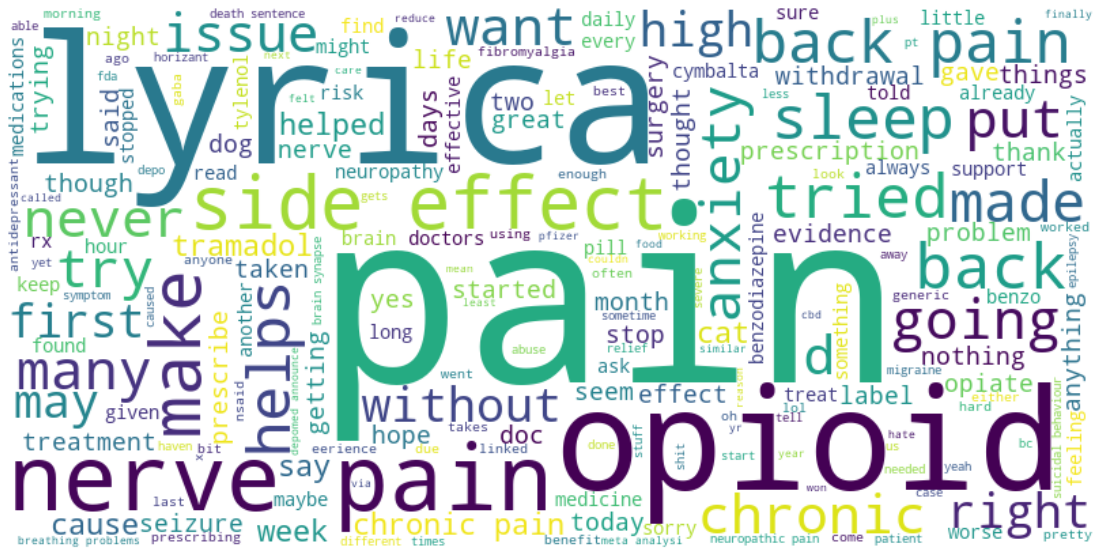

In [27]:
text = " ".join(tweet for tweet in tweets.tweet)

stopwords = set(STOPWORDS)
stopwords.update(["gabapentinoids", "gabapentin", "pregabalin", 'Neurontin', 'gralise', "still", "also", 'get', 'need', 'amp', 'one', 'much',
            'm', 's', 'take', 'drug', 'day', 'med', 've', 'use', 'don', 't', 'mg', 'now', 'help', 'work', 'know', 'good',
            'meds', 'medication', 'Im', 'time', 'like', 'im', 'prescribed', 'drugs', 'used', 'well', 'taking', 'dose', 
             'years', 'got', 'neurontin', 'people', 'think', 'really', 'took', 'would', 'new', 'patients', 'never'
            'tried', 'feel', 'works', 'go', 'even', 'bad', 'low', 'give', 'Dr', 'doctor', 'see', 'will', 'better', 'thing', 
            'u', 'lot', 'way', 're', 'doesn', 'didn', 'll', 'w', 'etc', 'vet', 'ye', 'isn', ])


wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate(text)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can see that, although we didn't look for tweets that mention 'lyrica', it's one of the most frequent words. The most frequent terms seem to be 'pain', 'nerve pain' and 'chronic pain'. 'Opioid' is also very frequent, something normal since gabapentinoids are often prescribed as an alternative to them. Other frequent terms are 'side effect', 'anxiety' and 'withdrawal'. 

<h2>SENTIMENT ANALYSIS</h2>

We are going to use different methods and compare the results. The first one is Textblob

In [28]:
tweets['blob_polarity'] = tweets['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

tweets['blob_subjectivity'] = tweets['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.subjectivity)

tweets[['id', "tweet", "blob_polarity","blob_subjectivity"]].sample(10)

,id,tweet,blob_polarity,blob_subjectivity
created_at,,,,
2019-09-25 14:39:08,1176838544419172352,i m not trying to be critical but i did it that way as well for almost years works significantly better utilizing all receptors being blocked with gabapentinoids nsaid up front tylenol up front etc but doing something is better than nothing btw clonidine gt gt dexmet,0.333333,0.600000
2021-05-26 21:05:48,1397630064544534528,hypertonic here lots of trigger points i find using a pelic wand as often as my body will tolerate to work manually really helps me also i have a compounded rx for lidocaine gabapentin ketoprofen gel to be used internally which helps a lot when flaring,0.100000,0.100000
2021-06-29 01:38:59,1409657610253455363,keppra is on my son s do not ever give again med list awful eerience gabapentin has been perfect for him neutral for side effects clears thru his kidneys only organ he has that works perfectly doesn t cause psychosis or rage like keppra,0.250000,1.000000
2021-04-22 08:29:58,1385118664710627328,and at the end he says for opioids gabapentinoids and cannabinoids the potential harms outweigh the potential benefits growl makes me feel so blinkety blinking helpless when medical authorities say the best thing is just to help us learn to live with the pain,0.227273,0.560000
2021-06-09 11:26:21,1402557672080224264,why is pregabalin lyrica still being prescribed as an anti epileptic drug it was never researched,0.000000,0.000000
2021-02-20 03:40:39,1362955295325122569,there s also a bunch of ssris like cymbalta and a whole class of nerve meds like neurontin and lyrica that help some people that your gp might be more comfortable trying,0.366667,0.566667
2021-06-16 22:42:01,1405264423388946437,i feel your pain my hand is tingling because of nerve palsy in my neck and shoulder i take neurontin for it see your gp to see if you can get it,0.000000,0.000000
2013-08-22 04:37:43,370374191943413761,one of the less common side effects listed on for gralise is coma this could be fun,-0.066667,0.191667
2019-02-23 23:05:07,1099429978607890434,upcoming alpha training the rise of a new epidemic benzodiazepines and gabapentinoids friday march st register here,0.136364,0.454545


Let's categorize the values:

In [29]:
def analyse_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity == 0:
        return "Neutral"
    if polarity < 0:
        return "Negative"

tweets["blob_sentiment"] = tweets["blob_polarity"].apply(analyse_polarity)

tweets["blob_sentiment"].value_counts()

Positive    5353
Neutral     3876
Negative    3565
Name: blob_sentiment, dtype: int64

It looks like more tweets are positive, let's see a graphic representation

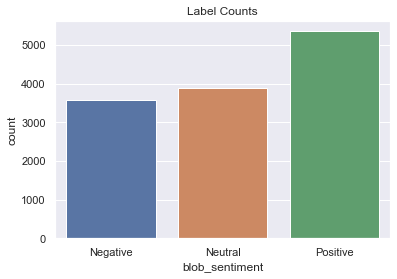

In [30]:
tweets["blob_sentiment"] = tweets["blob_sentiment"].astype("category")

sns.countplot(x=tweets["blob_sentiment"])
plt.title("Label Counts")
plt.show()

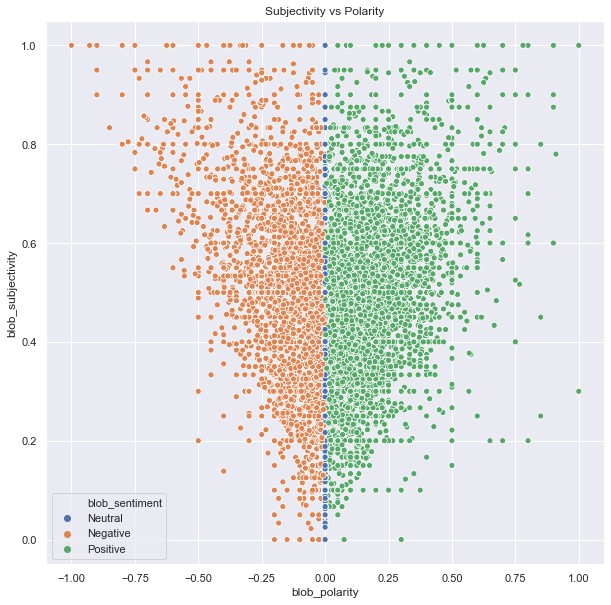

In [31]:
# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="blob_polarity", y="blob_subjectivity", hue="blob_sentiment", data=tweets)
plt.title("Subjectivity vs Polarity")
plt.show()

It seems that the most subjective tweets are also the most polarized. But the lexicon-based analysis is not always reliable, we have to check the results manually. So we are going to check the tweets with the highest polarity.

In [32]:
display(tweets.sort_values(by=["blob_polarity"], axis=0, ascending=False)[["tweet", "blob_polarity"]].head(20))

,tweet,blob_polarity
created_at,,
2021-06-03 09:35:17,gabapentin and tramadol difference side effects best food interaction,1.0
2021-05-16 21:01:55,no benefit to outpatient post cd gabapentin regimen best paper competition,1.0
2021-04-20 01:58:27,becareful with the gabapentin as all things serotonin monitor length best,1.0
2019-05-15 15:49:43,excellent talk by professor martin underwood on the use of opoids and gabapentinoids for chronic non malignant pain management,1.0
2020-10-28 17:44:33,waiting waiting waiting for my morning daytime meds and praying they take hold soon also doubled dose hour tylenol in case it takes two doses of neurontin since they re always touchy 50 50 and the longest of the two to kick in but the best of the two,1.0
2019-05-01 11:15:31,increasing use of gabapentinoids perpetuates a bias towards the pharmacological management of pain goodman and brett cited by prof george peat in excellent cprd study summary in oral abstract session,1.0
2021-06-01 04:52:43,gabapentin gives awesome heart fluttering feeling,1.0
2021-05-01 17:04:48,helen pass presenting on best papers gabapentin should not be used in eras protocols,1.0
2019-10-11 03:00:09,1 neurontin and 2 vicodin until the neurontin kicks in i had it three times best wishes and prayers for a swift recovery,1.0


The reason why these tweets have the highest polarity is because they include positive terms like 'best', 'excellent' or 'great', but very few of the tweets express a positive opinion about gabapentinoids. 

Now we are going to repeat the process using Vader Sentiment.

In [33]:
sid = SentimentIntensityAnalyzer()

tweets['vader_scores'] = tweets['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))

tweets[['id', 'tweet', 'blob_polarity', 'blob_subjectivity', 'blob_sentiment', 'vader_scores']].sample(5)

,id,tweet,blob_polarity,blob_subjectivity,blob_sentiment,vader_scores
created_at,,,,,,
2021-06-25 18:28:30,1408462112431742978,chlorpromazine doc metoclopramide baclofen haloperidol gabapentin,0.00,0.00,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2019-09-28 07:15:34,1177814080863834112,levocitazole stimulant used recreationally as an anxiolytic contraindicated by neurontin,0.00,0.00,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2019-10-20 16:27:29,1185925509344976896,neurontin is a joke useless,-0.50,0.20,Negative,"{'neg': 0.35, 'neu': 0.375, 'pos': 0.275, 'compound': -0.1531}"
2017-11-13 10:40:51,930007541219713025,be careful with neuromodulators like gabapentinoids generally low quality evidence for many indications unhelpful for back pain like nice opinion piece,0.20,0.56,Positive,"{'neg': 0.181, 'neu': 0.503, 'pos': 0.315, 'compound': 0.4588}"
2019-09-01 08:01:32,1168041178828177408,i don t remember that moment at the peacock room orlando in that photo with joe i remember the show but we smoked before we left i had a couple double hennessy and cokes at the bar the venue really is just a bar with a small stage and i definitely took some neurontin,-0.01,0.22,Negative,"{'neg': 0.0, 'neu': 0.937, 'pos': 0.063, 'compound': 0.5499}"


Let's categorize the compound values:

In [34]:
tweets['vader_polarity'] = tweets['vader_scores'].apply(lambda score_dict: score_dict['compound'])

def analyse_compound(compound):
    if compound > 0:
        return "Positive"
    if compound == 0:
        return "Neutral"
    if compound < 0:
        return "Negative"
    
tweets["vader_sentiment"] = tweets['vader_polarity'].apply(analyse_compound)

tweets[['blob_polarity', 'blob_subjectivity', 'blob_sentiment', 'vader_scores', 'vader_sentiment']].head()

,blob_polarity,blob_subjectivity,blob_sentiment,vader_scores,vader_sentiment
created_at,,,,,
2011-01-29 01:35:33,0.0,0.0,Neutral,"{'neg': 0.0, 'neu': 0.567, 'pos': 0.433, 'compound': 0.7269}",Positive
2011-01-29 01:36:01,0.0,0.0,Neutral,"{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.4215}",Positive
2011-01-29 01:42:27,0.0,0.0,Neutral,"{'neg': 0.0, 'neu': 0.838, 'pos': 0.162, 'compound': 0.4767}",Positive
2011-01-29 01:54:33,0.0,0.0,Neutral,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'compound': 0.7003}",Positive
2011-01-29 01:58:40,0.0,0.0,Neutral,"{'neg': 0.0, 'neu': 0.78, 'pos': 0.22, 'compound': 0.4767}",Positive


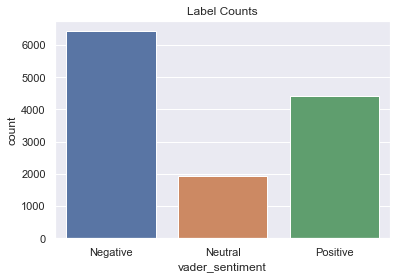

In [35]:
tweets["vader_sentiment"] = tweets["vader_sentiment"].astype("category")

sns.countplot(x=tweets["vader_sentiment"])
plt.title("Label Counts")
plt.show()

Vader sentiment has classified more tweets as negative. Let's see what punctuation gives to the tweets with the highest polarity.

In [36]:
display(tweets.sort_values(by=["blob_polarity"], axis=0, ascending=False)[["tweet", "vader_polarity", 'blob_polarity']].head(20))

,tweet,vader_polarity,blob_polarity
created_at,,,
2021-06-03 09:35:17,gabapentin and tramadol difference side effects best food interaction,0.6369,1.0
2021-05-16 21:01:55,no benefit to outpatient post cd gabapentin regimen best paper competition,0.4059,1.0
2021-04-20 01:58:27,becareful with the gabapentin as all things serotonin monitor length best,0.6369,1.0
2019-05-15 15:49:43,excellent talk by professor martin underwood on the use of opoids and gabapentinoids for chronic non malignant pain management,0.1027,1.0
2020-10-28 17:44:33,waiting waiting waiting for my morning daytime meds and praying they take hold soon also doubled dose hour tylenol in case it takes two doses of neurontin since they re always touchy 50 50 and the longest of the two to kick in but the best of the two,0.8201,1.0
2019-05-01 11:15:31,increasing use of gabapentinoids perpetuates a bias towards the pharmacological management of pain goodman and brett cited by prof george peat in excellent cprd study summary in oral abstract session,0.0000,1.0
2021-06-01 04:52:43,gabapentin gives awesome heart fluttering feeling,0.8689,1.0
2021-05-01 17:04:48,helen pass presenting on best papers gabapentin should not be used in eras protocols,0.6369,1.0
2019-10-11 03:00:09,1 neurontin and 2 vicodin until the neurontin kicks in i had it three times best wishes and prayers for a swift recovery,0.7650,1.0


We can see that most of the tweets with the highest blob polarity also have a high vader polarity.

Now we repeat the process using flair

In [37]:
classifier = TextClassifier.load('en-sentiment')

2021-07-13 20:03:36,549 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to C:\Users\marca\AppData\Local\Temp\tmpmowcykmf


100%|████████████████████████████████████████████████████████████████| 265512723/265512723 [01:45<00:00, 2518595.81B/s]

2021-07-13 20:05:22,212 copying C:\Users\marca\AppData\Local\Temp\tmpmowcykmf to cache at C:\Users\marca\.flair\models\sentiment-en-mix-distillbert_4.pt


2021-07-13 20:05:22,523 removing temp file C:\Users\marca\AppData\Local\Temp\tmpmowcykmf
2021-07-13 20:05:22,557 loading file C:\Users\marca\.flair\models\sentiment-en-mix-distillbert_4.pt


In [38]:
def flair_get_score_tweet(text):
  if not text:
    return 0
  s = Sentence(text)
  classifier.predict(s)
  value = s.labels[0].to_dict()['value'] 
  if value == 'POSITIVE':
    result = s.to_dict()['labels'][0]['confidence']
  else:
    result = -(s.to_dict()['labels'][0]['confidence'])
  return round(result, 3)

def sentiment_analysis_flair(polarity):
  if polarity > 0:
    return 'Positive'
  if polarity == 0:
    return 'Neutral'
  if polarity < 0:
    return 'Negative'

In [40]:
tweets['flair_score'] = tweets['tweet'].apply(flair_get_score_tweet)

tweets['flair_sentiment'] = tweets['flair_score'].apply(sentiment_analysis_flair)

tweets[['tweet', 'blob_sentiment', 'vader_sentiment', 'flair_sentiment']].sample(5)

,tweet,blob_sentiment,vader_sentiment,flair_sentiment
created_at,,,,
2018-02-16 22:33:44,looks like theyre going after gabapentinoids though those are used for pain as well how is it moral to take pain medications away and not have affordable replacements,Neutral,Negative,Negative
2019-08-23 22:34:29,unisom will help too it s a first gen anti histamine that is what makes you sleepy in nyquil klonopin works great too but is addictive and can leave you groggy the next day if you take too much try the neurontin lemme know of a po box if you need any it s expensive,Positive,Negative,Positive
2021-06-16 10:02:35,this is why conservative management didn t really work this is why ibuprofen and paracetamol have barely touched the sides and the ibu has reflux side effects but my pregabalin helps half the pain because it s a bloody nerve,Negative,Negative,Negative
2021-06-20 21:20:32,administering gabapentin along with antivirals may offer relief of,Neutral,Positive,Positive
2020-10-27 21:07:24,dont worry you guys arent missing out on much at best oral analgesics maybe confer marginal improvement in pain at best and gabapentinoids have not been shown in rcts to improve sciatica compressed nerve root related pain,Positive,Positive,Negative


Flair takes a long time to process all tweets, so I'm going to save the results in a csv file to save time.

In [ ]:
tweets.to_csv('tweets.csv')

In [44]:
tweets = pd.read_csv('tweets.csv')

tweets[['id', 'tweet', 'flair_sentiment']].sample(5)

,id,tweet,flair_sentiment
552,322228962707263488,hmm depo took price increases on gralise 9 and zipsor 40 last week price incr to help offset script weakness according to roth,Negative
9812,1396889049760153602,gabapentin is what i take it helps a ton,Positive
11820,1405633057021992965,she needs gabapentin and she hates it,Negative
7034,1372228117289443336,2 in ivc thrombosis atresia epidural venous plexus is engorged and pts can have sig this sig improves after ivc iliac recan once inflammation from pta stenting has resolved month we give pts dilaudid neurontin and medrol dose pack on discharge,Negative
989,857161220985683968,gralise anatomy,Positive


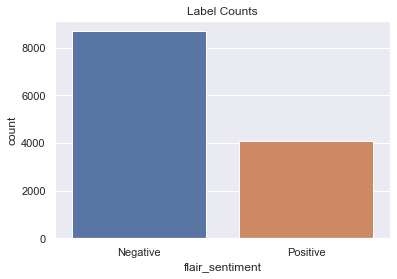

In [45]:
tweets["flair_sentiment"] = tweets["flair_sentiment"].astype("category")

sns.countplot(x=tweets["flair_sentiment"])
plt.title("Label Counts")
plt.show()

We see that flair classifies tweets only as positive or negative. We also see that the same tweet can be classified as positive, neutral or negative depending of the method we use. Let's see the percentage of times these algorithms agree with one another when classifying the sentiment of a tweet.

In [46]:
from sklearn.metrics import accuracy_score

print(f"Consensus TextBlob - VADER: {accuracy_score(tweets['blob_sentiment'],tweets['vader_sentiment']):.4}")
print(f"Consensus TextBlob - Flair: {accuracy_score(tweets['blob_sentiment'],tweets['flair_sentiment']):.4}")
print(f"Consensus VADER - Flair: {accuracy_score(tweets['vader_sentiment'],tweets['flair_sentiment']):.4}")

Consensus TextBlob - VADER: 0.5325
Consensus TextBlob - Flair: 0.3942
Consensus VADER - Flair: 0.5507


The two methods with the highest consensus are Vader and Flair, followed by TextBlob and VADER.

In [47]:
def consensus(row):
    count = 0
    count += row['blob_sentiment']==row['vader_sentiment']
    count += row['blob_sentiment']==row['flair_sentiment']
    count += row['vader_sentiment']==row['flair_sentiment']

    return count

tweets['consensus'] = tweets.apply(lambda row: consensus(row), axis=1)

tweets['consensus'].value_counts()

1    7991
3    3637
0    1166
Name: consensus, dtype: int64

We have almost 4000 tweets with the same sentiment for all three methods, and almost 8000 classified with the same sentiment by two methods.

In [48]:
all_three = tweets[tweets['consensus'] == 3]

all_three[['id', 'tweet', 'blob_sentiment', 'vader_sentiment', 'flair_sentiment']].sample(5)

,id,tweet,blob_sentiment,vader_sentiment,flair_sentiment
6756,1353241371721814016,would probably not get worse over time but also wouldn t get better i hate it having to make the ish mile drive every other week is not fun i have tried neurontin and lyrics the side effects sucked,Negative,Negative,Negative
7238,1383915142593748995,lol i need caffeine now because the gabapentin,Positive,Positive,Positive
4316,1208050734660501504,we do not want to unintentionally increase opioid use by turning prescribers away from this class of pain medications he added the hazards of the fake opioid crisis fda warns of breathing problems with gabapentinoids,Negative,Negative,Negative
7020,1370867720955174919,you get used to it i ve lived like this for my whole life much accelerated by the neurontin tho i mainly remember family as they looked in the months before i went on it sometimes startles me,Positive,Positive,Positive
3053,1150421272398114817,its frightening to think about the long term effects of dangerous drugs like neurontin along with the other anti seizure and antidepressant meds theyre hawking for pain,Negative,Negative,Negative


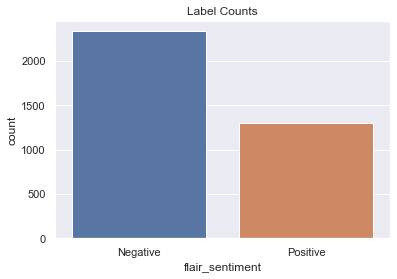

In [49]:
sns.countplot(x=all_three["flair_sentiment"])
plt.title("Label Counts")
plt.show()

We can see that, when all three methods agree, they classify most of the tweets as negative. Let's see what happen when only two methods agree. First, we check the tweets where VADER and Flair agree.

In [50]:
just_two = tweets[tweets['consensus'] == 1]

vader_flair = just_two[just_two['vader_sentiment'] == just_two['flair_sentiment']]

vader_flair[['id', 'tweet', 'vader_sentiment', 'flair_sentiment']].sample(5)

,id,tweet,vader_sentiment,flair_sentiment
10681,1400748911715885056,he has arthritis in his neck is what the vet determined so hes on gabapentin and galiprant hes fine when the meds are working but as they wear off he becomes restless,Negative,Negative
1219,898582934734618624,bmj 358 j3870 gabapentinoids do not help chronic low back pain,Negative,Negative
1609,965608035128397824,the article suggests people may be taking it as an alternative to opioids but they aren t everyone finally figured out that gabapentinoids potentiate other drugs and alcohol but they do little to nothing pleasant on their own,Negative,Negative
9773,1396677879069618179,how much gabapentin does it take to kill someone,Negative,Negative
5039,1232968216143630336,pregabalin you will feel drunk without the alcohol neurontin you know that feeling weed gives you where you cant get off the couch well same thing but without the high amitriptyline im going to take away your neuropathy but make you gain lbs in days,Positive,Positive


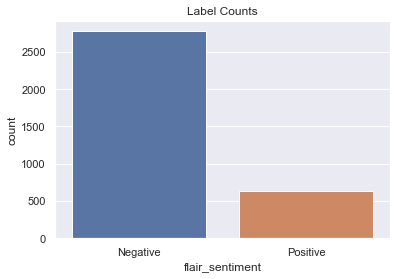

In [51]:
sns.countplot(x=vader_flair["flair_sentiment"])
plt.title("Label Counts")
plt.show()

When VADER and Flair agree, most of the tweets are classified as negative. Let's see what happen when TextBlob and VADER agree.

In [52]:
blob_vader = just_two[just_two['blob_sentiment'] == just_two['vader_sentiment']]

blob_vader[['id', 'tweet', 'blob_sentiment', 'vader_sentiment']].sample(5)

,id,tweet,blob_sentiment,vader_sentiment
9901,1397161715557707777,there are really good reasons to use meds off label there are even conditions for which there are no labeled meds but good data labeling is very much a business decision but of gabapentin prescriptions are off label like wow,Positive,Positive
10421,1399518120922939394,i have these same issues for me it is neuropathy pain that stems from my neuromuscular condition cmt i take gabapentin daily and it seems to help im also more sensitive in hot or really cold weather i hope you feel better soon,Positive,Positive
3452,1171462328312745986,just heard gabapentinoids included in the prescription for rotten life syndrome if physical therapies work better why are the referrals to the gym for the decrepit weeks at best,Positive,Positive
6505,1339004002592321538,one thing i ve found recently that helps is an old school blood pressure med named clonidine muffles the nervous system like lyrica or gabapentin neurontin but for me works better with fewer side effects,Positive,Positive
2541,1134840381282050048,i think drs should try some of these meds that they believe are safe id love to see some of these drs walking around on neurontin gabepentin,Positive,Positive


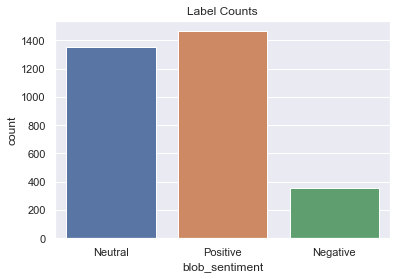

In [53]:
sns.countplot(x=blob_vader["blob_sentiment"])
plt.title("Label Counts")
plt.show()

TextBlob and VADER have a 'Neutral' category, and TextBlob classifies most of the tweets as 'Positive' and 'Neutral', so we see the same results when both methods agree. Now let's check the tweets where TextBlob and Flair agree.

In [54]:
blob_flair = just_two[just_two['blob_sentiment'] == just_two['flair_sentiment']]

blob_flair[['id', 'tweet', 'blob_sentiment', 'flair_sentiment']].sample(5)

,id,tweet,blob_sentiment,flair_sentiment
6673,1349332980825731074,not really we ve discussed this few times multi agency review panels gabapentinoids been mentioned as possible and the surge in new benzo s like phenazepam and flualprazolam but the former has been around for a while now the latter is possibly a reaction to drug supply,Negative,Negative
3494,1173255846555521025,i was on mg of neurontin but the capsules came in mg so was much easier to reduce then the clonazepam i could cut the tablet in halfs and then quarters which helped just try and do it as slow as you can,Negative,Negative
11209,1402826017023172609,gabapentin has become the go to drug for those already injured by benzos many docs prescribe it for benzo withdrawal while short term relief is possible i have experienced extreme states of suffering with gbp withdrawal the taper is brutal a fact most doctors deny,Positive,Positive
3693,1184488610013294597,phe report one in four adults were prescribed one or more of bzds z drugs gabapentinoids opioids or anti depressants between 2018 in england this represents million adults extraordinary via,Positive,Positive
12476,1408783528960180228,the psychological effects are nowhere near as bad as the gabapentin that i was prescribed which was so bed i stopped taking it,Negative,Negative


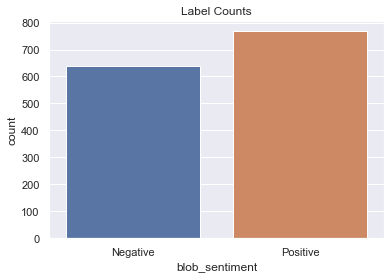

In [55]:
sns.countplot(x=blob_flair["blob_sentiment"])
plt.title("Label Counts")
plt.show()

The number of positive and negative tweets is almost the same.

<h2>CONCLUSION</h2>

I think every method has its pros and cons. I also think that the results vary when we apply them to unprocessed text. I will try other methods and techniques for data gathering, data cleaning and text analysis.